In [1]:
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cmocean as cmo

In [2]:
# load data
data = np.load("sentinel2_rochester.npy")
data_copy = copy.deepcopy(data) # safety standard
# data_copy

In [3]:
# defining the labels for each band
labels = [
            "B1 - 60 m - 443 nm - Ultra Blue (Coastal and Aerosol)",
            "B2 - 10 m - 490 nm - Blue",
            "B3 - 10 m - 560 nm - Green",
            "B4 - 10 m - 665 nm - Red",
            "B5 - 20 m - 705 nm - VNIR",
            "B6 - 20 m - 740 nm - VNIR",
            "B7 - 20 m - 783 nm - VNIR",
            "B8 - 10 m - 842 nm - VNIR",
            "B8a - 20 m - 865 nm - VNIR",
            "B9 - 60 m - 940 nm - SWIR",
            "B11 - 20 m - 1610 nm - SWIR",
            "B12 - 20 m - 2190 nm - SWIR"
]


In [4]:
#prob 1: handling of no data with nan replacement
def replace_with_nan(arr: np.ndarray, no_data_value = 0):
    nan_replaced = arr.astype(float, copy=True)
    nan_replaced[arr == no_data_value] = np.nan # dam i love the automcomplete here lol
    return nan_replaced
no_nan_data = replace_with_nan(data_copy, no_data_value = 0)
# no_nan_data

In [5]:
"""
Problem 1 stuff:
- stretching codes
"""

'\nProblem 1 stuff:\n- stretching codes\n'

In [6]:
def minmax_stretch(img):
    low = np.nanmin(img)
    high = np.nanmax(img)
    output = (img-low)/(high-low)
    return np.clip(output, 0, 1).astype(np.float32) #ensuring consistency in datatypes and clipping the output since did normalization.


def percentile_stretch(img, low_perc=10, high_per=90):
    low = np.nanpercentile(img, low_perc)
    high = np.nanpercentile(img, high_per)
    if not np.isfinite(low) or not np.isfinite(high) or high<=low:
        return np.zeros_like(img, dtype=np.float32)
    output = (img-low)/(high-low)
    return np.clip(output, 0, 1).astype(np.float32)

In [7]:
"""
- define the plot_band(args) function. Stitching up whatever I have written so far in a neat manner.
"""

'\n- define the plot_band(args) function. Stitching up whatever I have written so far in a neat manner.\n'

In [8]:
def plot_band(img: np.ndarray,
              band_i: int,
              cmap_name: str = "thermal",
              stretch: tuple | None = ("percentile",3,97),
              show_colorbar: bool = True,
              title: str | None = None,
              nodata: float | int | None = None
              ) -> None:
    img = img[:,:,band_i].astype(np.float32, copy=True) # plotting per band
    if nodata is not None:
        img[img == nodata] = np.nan
    if stretch is None:
        img_stretch = img
    elif stretch[0] == "percentile":
        img_stretch = percentile_stretch(img, stretch[1],stretch[2])
    elif stretch[0] == "minmax":
        img_stretch = minmax_stretch(img)
    else:
        raise ValueError("stretch must be: 'percentile' or 'minmax' or None")
    cmap = getattr(cmo.cm, cmap_name).copy()
    cmap.set_bad('black') # setting the nans to black. But I do not understand why they show up as white, maybe probably due to
    plt.imshow(img_stretch, cmap = cmap)
    plt.title(title or f"{labels[band_i]} - {stretch[0]} = {stretch[1]}-{stretch[2]}%")
    plt.axis("off")
    if show_colorbar:
        plt.colorbar()
    plt.show()
    return None


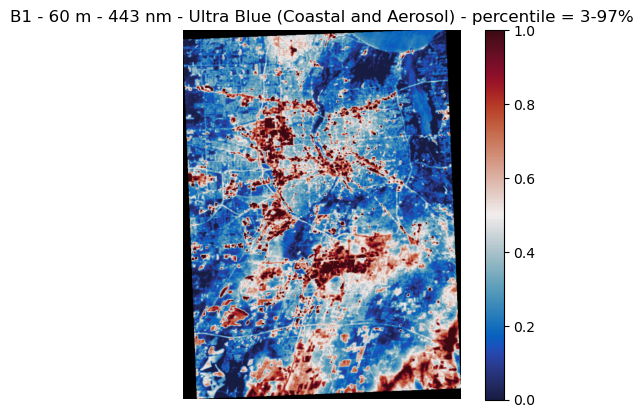

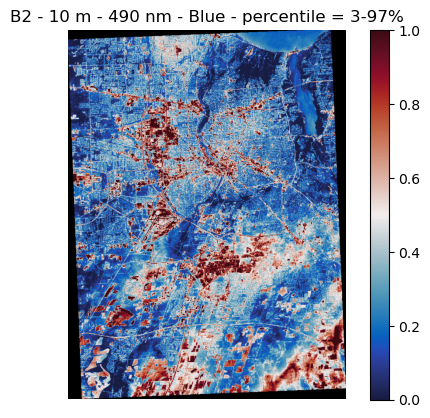

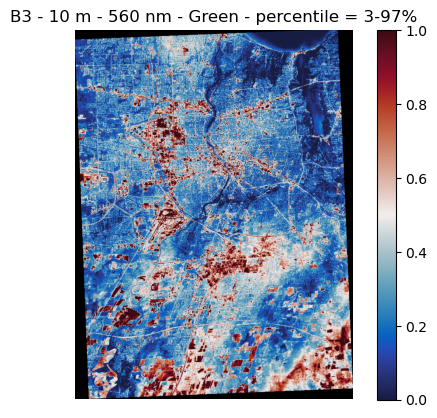

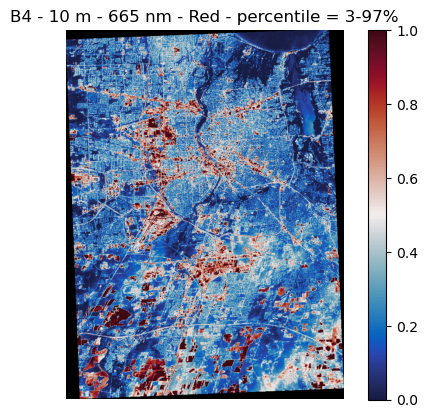

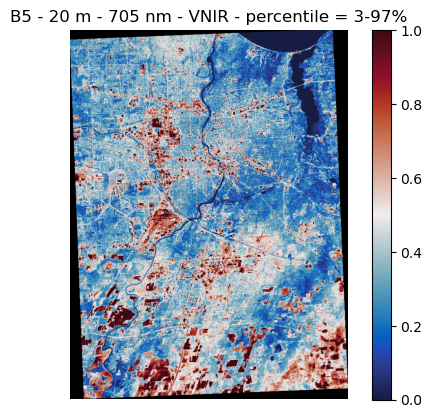

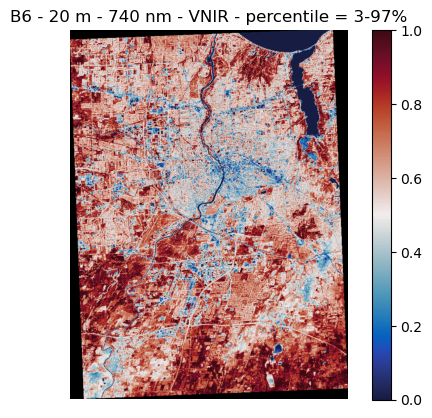

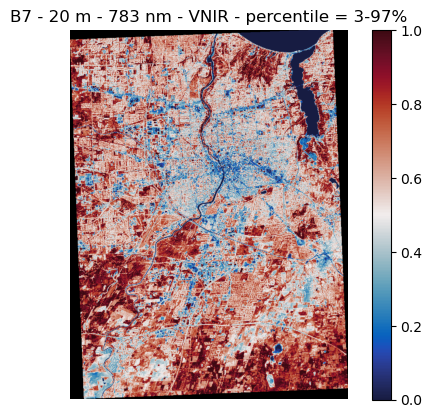

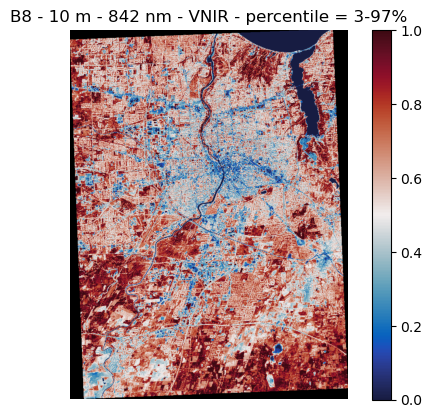

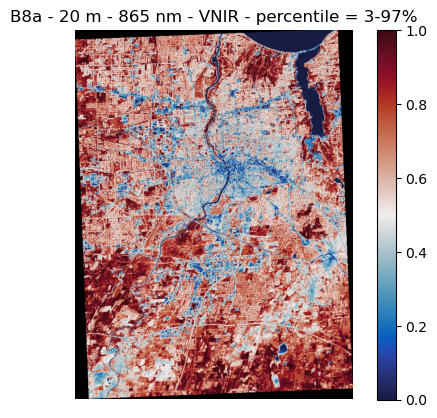

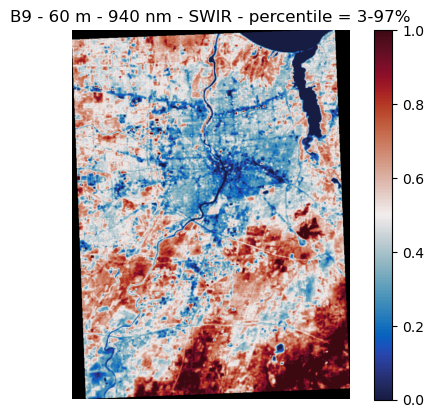

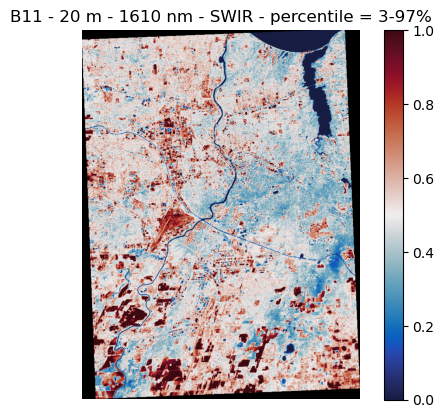

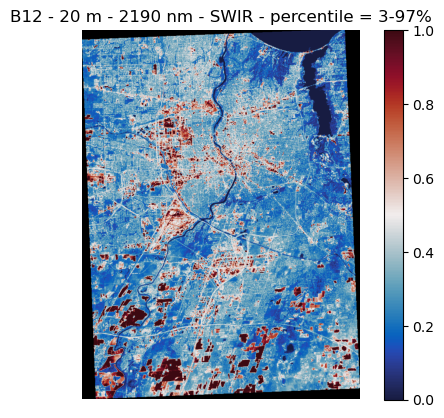

In [9]:
# looping through all the bands

for i in range(data_copy.shape[-1]):
    plot_band(img = no_nan_data,
              band_i = i,
              cmap_name = "balance",
              stretch = ("percentile",3,97),
              show_colorbar = True)


In [10]:
"""
Problem 2 stuff:
a. stats = calculate_band_statistics(args)
I have already written this in HW1.ipynb
"""

'\nProblem 2 stuff:\na. stats = calculate_band_statistics(args)\nI have already written this in HW1.ipynb\n'

In [11]:
def calculate_band_statistics(img: np.ndarray, ):
    stats=[]
    for i in range(img.shape[-1]):
        band = img[:,:,i]
        label = labels[i]
        mean = np.nanmean(band)
        std = np.nanstd(band)
        q1, median, q3 = np.nanpercentile(band, [25, 50, 75])
        #statistical measures derived from moments that describe the shape of a frequency distribution
        skew = np.nanmean(((band-mean)/std)**3) # degree of assymetry around the mean (positive => right skewed, bright anomalies for us. High reflectance, so either rooftops and clouds and stuff) (negative => left skewed or dull anomalies or shadowed or water stuff)
        kurt = np.nanmean(((band-mean)/std)**4) #(>3 outliers more than normal) (degree of peakedness or heaviness of tails relative to normal distribution)(<3 fewer outliers than normal)
        stats.append([label, mean, median, q1, q3, std, skew, kurt])
    cols = ['label', 'mean', 'median', 'q1', 'q3', 'std', 'skew', 'kurt']
    band_stats_df = pd.DataFrame(stats, columns=cols)
    return pd.DataFrame(stats, columns=cols)

In [12]:
stats_df = calculate_band_statistics(no_nan_data)
stats_df.to_csv("band_statistics.csv", index=False)
stats_df

label      mean  median  \
0   B1 - 60 m - 443 nm - Ultra Blue (Coastal and A...  0.088682  0.0829   
1                           B2 - 10 m - 490 nm - Blue  0.092542  0.0853   
2                          B3 - 10 m - 560 nm - Green  0.105496  0.0987   
3                            B4 - 10 m - 665 nm - Red  0.094311  0.0850   
4                           B5 - 20 m - 705 nm - VNIR  0.136721  0.1310   
5                           B6 - 20 m - 740 nm - VNIR  0.243593  0.2472   
6                           B7 - 20 m - 783 nm - VNIR  0.285838  0.2903   
7                           B8 - 10 m - 842 nm - VNIR  0.291384  0.2976   
8                          B8a - 20 m - 865 nm - VNIR  0.303507  0.3098   
9                           B9 - 60 m - 940 nm - SWIR  0.345083  0.3446   
10                        B11 - 20 m - 1610 nm - SWIR  0.191718  0.1889   
11                        B12 - 20 m - 2190 nm - SWIR  0.129180  0.1204   

        q1      q3       std      skew       kurt  
0   0.0709  0.1007  0.027914  2.920508  26.797392  
1   0.0716  0.1053  0.035001  4.478896  46.108045  
2   0.0858  0.1168  0.034365  4.692240  49.293076  
3   0.0663  0.1093  0.044454  3.231439  26.407628  
4   0.1152  0.1506  0.040905  3.108017  30.351370  
5   0.2131  0.2830  0.061036 -0.708535   6.406103  
6   0.2444  0.3377  0.077305 -0.710117   4.720142  
7   0.2475  0.3464  0.080328 -0.716092   4.422177  
8   0.2605  0.3595  0.082224 -0.821525   4.674276  
9   0.3052  0.3882  0.077947 -0.395654   5.210019  
10  0.1710  0.2086  0.048364  0.521929   9.436293  
11  0.1020  0.1427  0.048550  1.949858  11.038139

In [13]:
"""
b. standardize data using z-scores
Why bother?
    From the above stats, every band has varying means and variances.
    Standardizing the bands would make it possible for us to compare one band with another. Will help us identify anomalies. it would just standardize around the respective means, letting us properly assess the relative distributions, and easily identify the outliers.
And then plotting histograms for the before (raw reflectances) & after (standardized values z-scores with

centered around mean and normalized with std dev
"""

'\nb. standardize data using z-scores\nWhy bother?\n    Well from the above stats, every band has varying means and variances, and it should be due to the different "Bands" at which the data was recorded.\n    Standardizing the bands would make it possible for us to compare one band with another. Will help us identify anomalies.\nAnd then plotting histograms for the before (raw reflectances) & after (standardized values z-scores with\n\ncentered around mean and normalized with std dev\n'

In [14]:
def standardize(img: np.ndarray):
    ht, wd, band = img.shape
    z = np.empty((ht, wd, band), dtype=np.float32)
    for b in range(band):
        band = img[:,:,b]
        mu = np.nanmean(band)
        sigma = np.nanstd(band)
        if not np.isfinite(sigma) or sigma == 0: #egde case to handle no data or whatevs
            z[:,:,b] = np.nan
        else:
            z[:,:,b] = (band-mu)/sigma
    return z



In [15]:
z = standardize(no_nan_data)
# z[500,200,6]

In [16]:
"""
problem 2 b) plotting the histograms
"""

'\nproblem 2 b) plotting the histograms\n'

In [17]:
# |z|>k is a good heuristic for anomalies detections in rs. experimented with 0.5 till 3.0
# i settle with around 2.2, where datapoints out of the ~80% of the whole distribution are being considered anomalies.
def histogram_before_after_standardization_z_score(img_raw: np.ndarray, z: np.ndarray, b: int, label: str, bins: int = 120, z_thresh: float = 2.2  ):
    raw = img_raw[:,:,b].ravel()
    raw = raw[np.isfinite(raw)]
    z = z[:,:,b].ravel()
    z = z[np.isfinite(z)]

    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].hist(raw, bins=bins,color = "blue")
    axes[0].set_title(f"{label} - before")
    axes[0].set_xlabel("raw_before")
    axes[0].set_ylabel("pixel_count")

    axes[1].hist(z, bins=bins,color = "red")
    axes[1].axvline(-z_thresh, ls="--", lw=1, color="black")
    axes[1].axvline(z_thresh, ls="--", lw=1, color="black")
    axes[1].set_title(f"{label} - z-scores (|z| > {z_thresh})")
    axes[1].set_xlabel("after_z_score")
    axes[1].set_ylabel("pixel_count")

    plt.tight_layout()
    plt.show()


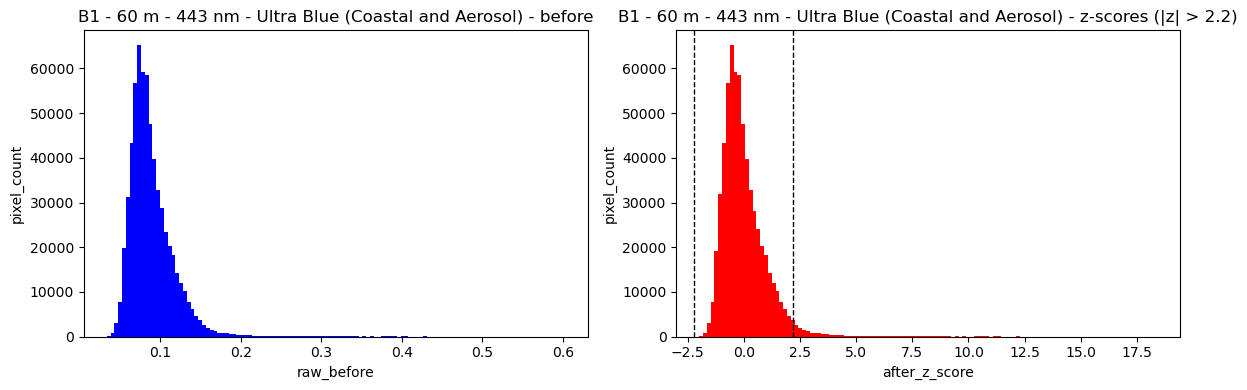

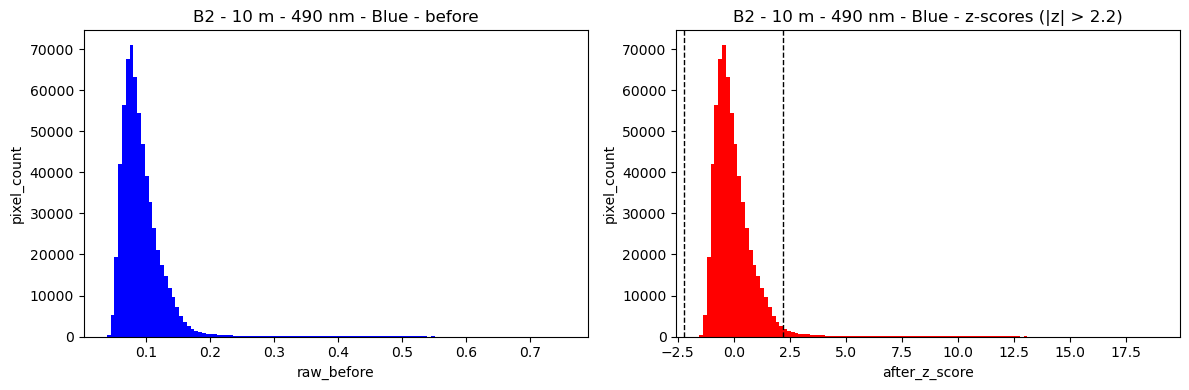

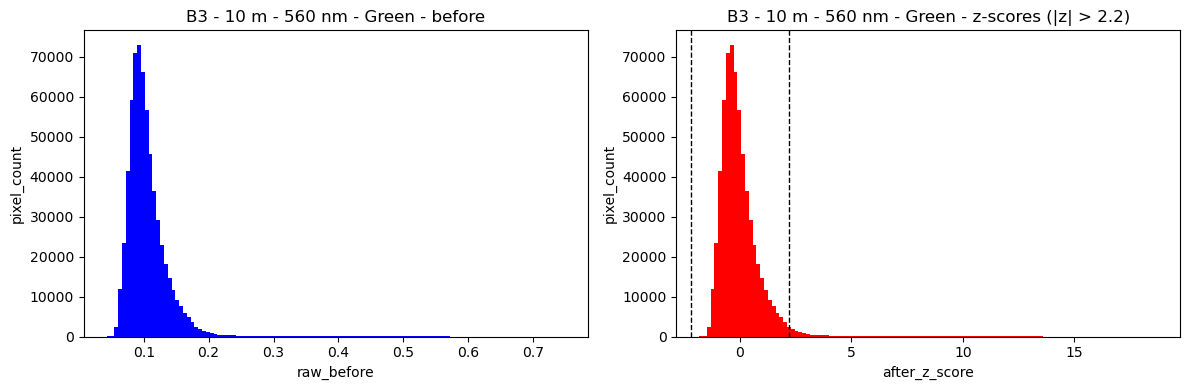

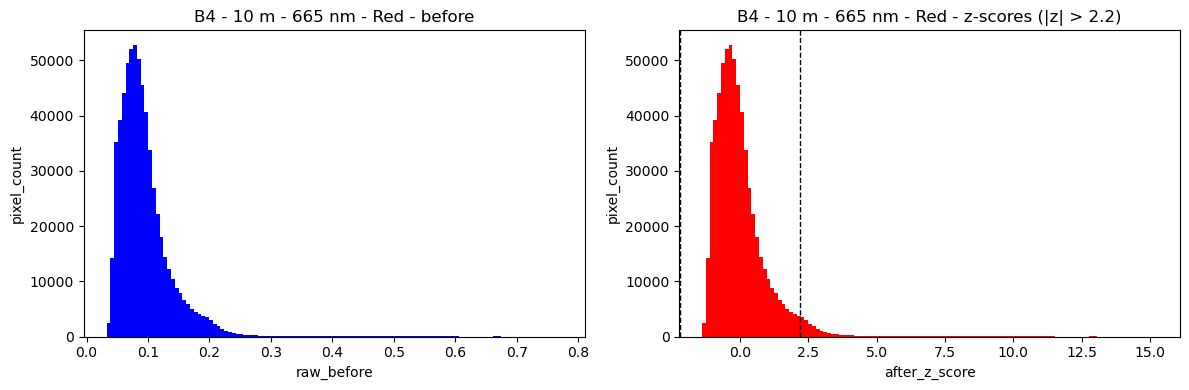

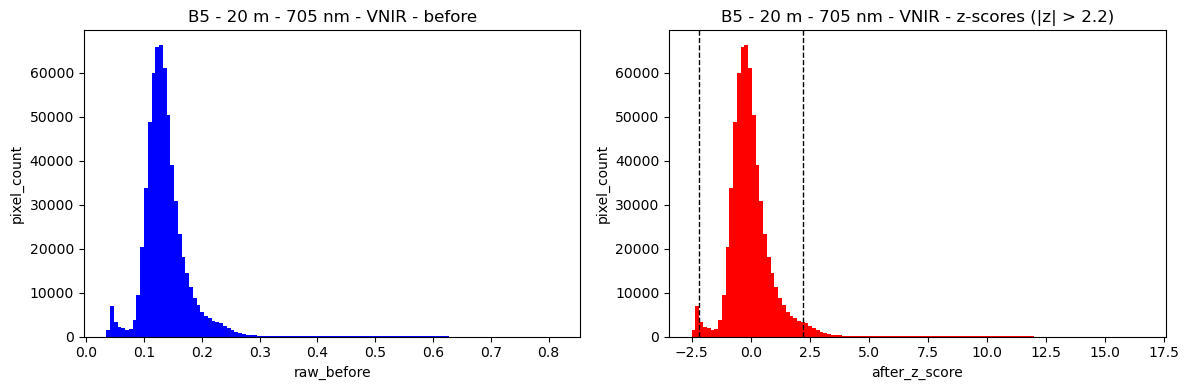

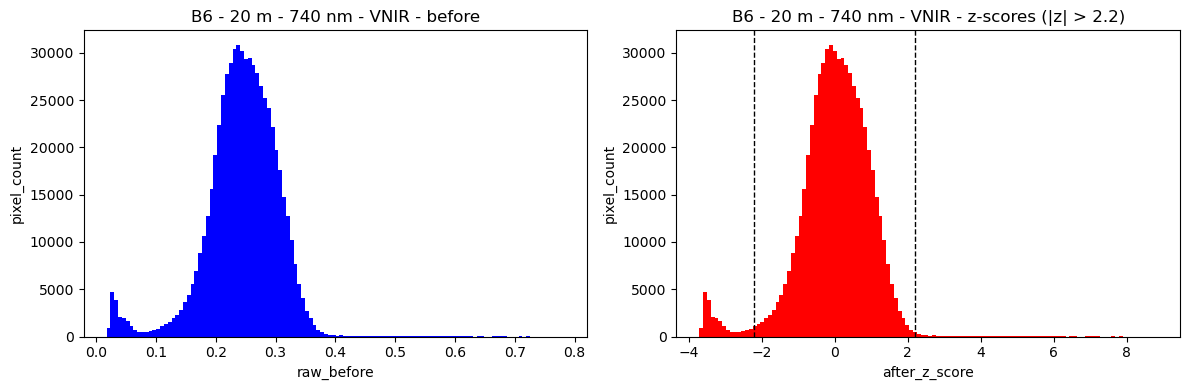

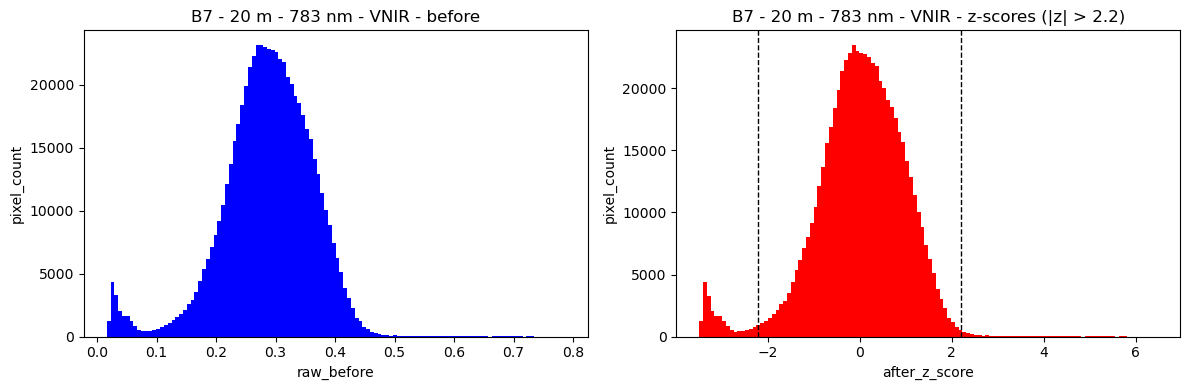

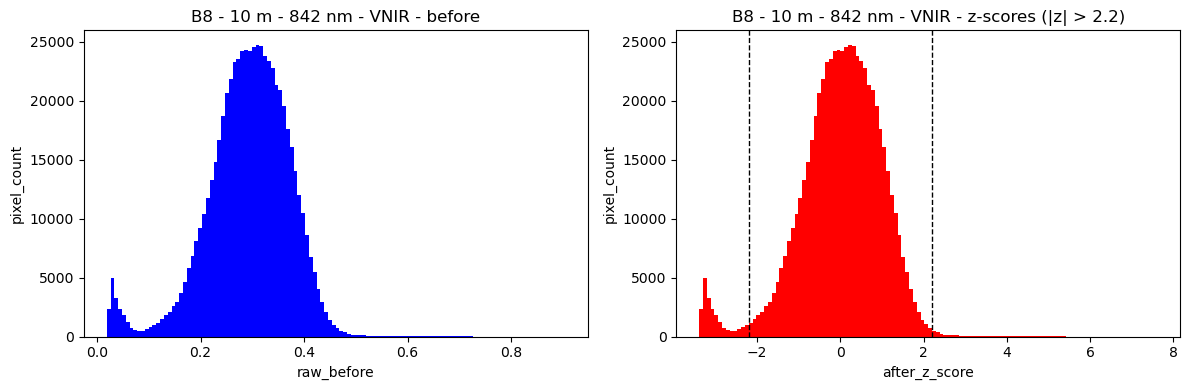

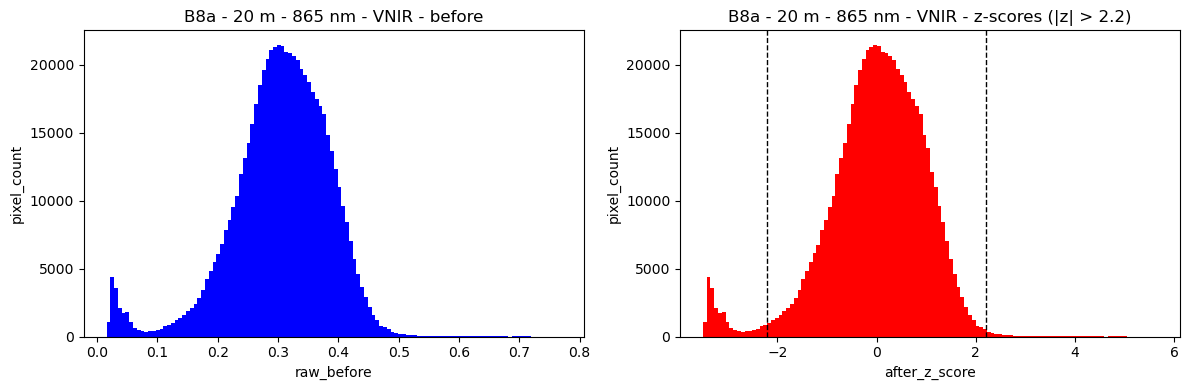

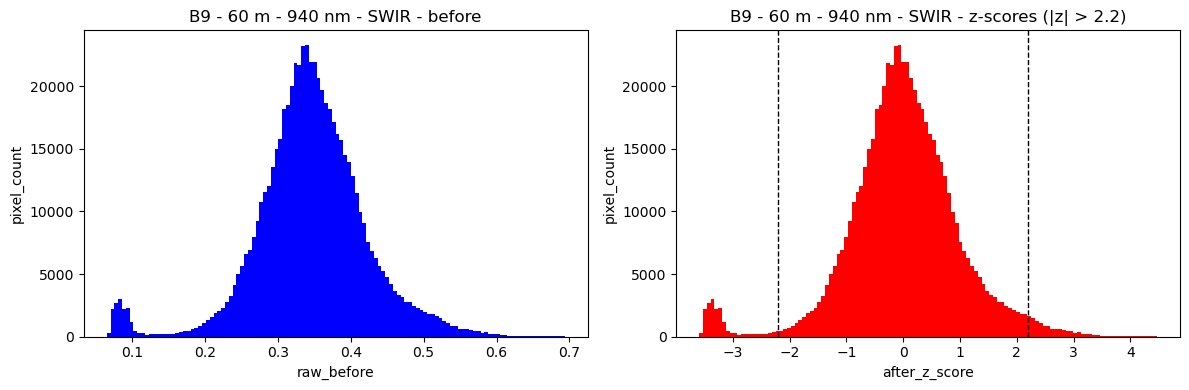

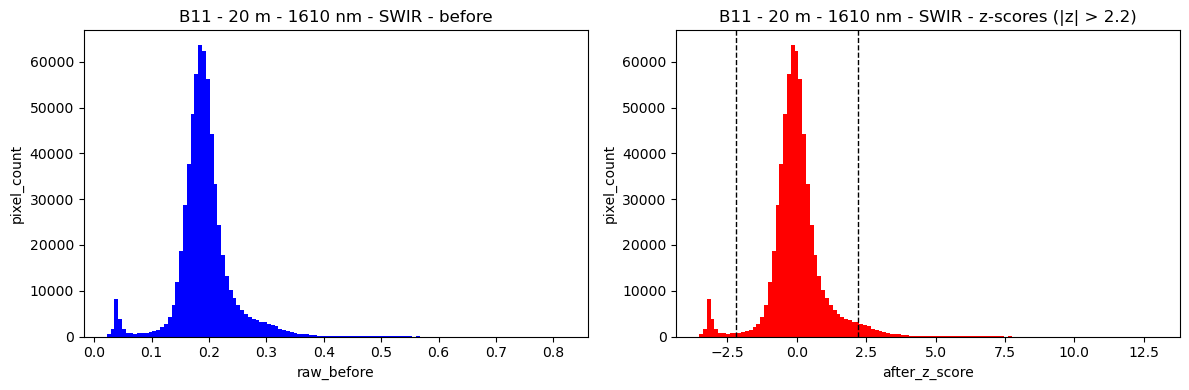

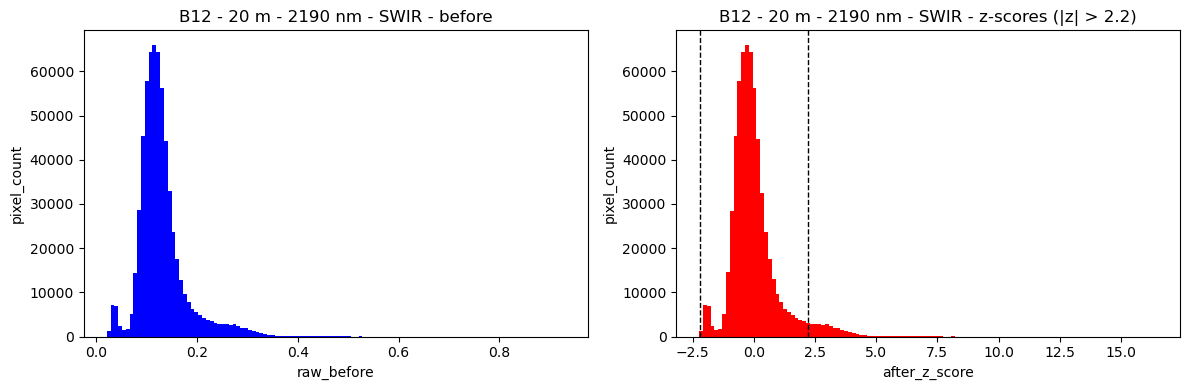

In [18]:
for b in range(no_nan_data.shape[-1]):
    histogram_before_after_standardization_z_score(no_nan_data, z, b, labels[b])


In [19]:
"""
problem 3a:
- correlation_matrix(args) to be built using pearson r correlation

"""

'\nproblem 3a:\n- correlation_matrix(args) to be built using pearson r correlation\n\n'

In [56]:
def correlation_matrix(img: np.ndarray, band_labels: list[str]) -> np.ndarray:
    x = img.reshape(-1, img.shape[-1]) #convert 3d to 2d or flatten it to 2d
    drop_nans = np.all(np.isfinite(x), axis=1)
    x_no_nans = x[drop_nans] #dropped the nans
    corr = np.corrcoef(x_no_nans,rowvar=False) #
    plt.figure(figsize=(12,12))
    corr_plt = plt.imshow(corr, vmin=-1, vmax=1, cmap=cmo.cm.ice)
    plt.colorbar(corr_plt, label="pearson_r")

    b = corr.shape[0]
    if band_labels is not None:
        plt.xticks(range(b), band_labels, rotation=80, fontsize=8)
        plt.yticks(range(b), band_labels, fontsize=8)
    else:
        plt.xticks(range(b))
        plt.yticks(range(b))

    for i in range(b):
        for j in range(b):
            plt.text(j, i, f"{corr[i, j]:.2f}",
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="black" if abs(corr[i, j]) < 0.50 else "yellow",
                     fontsize=8 if abs(corr[i, j]) < 0.50 else 12)
    plt.title("band-band_correlation_matrix")
    plt.tight_layout()
    plt.show()
    return corr



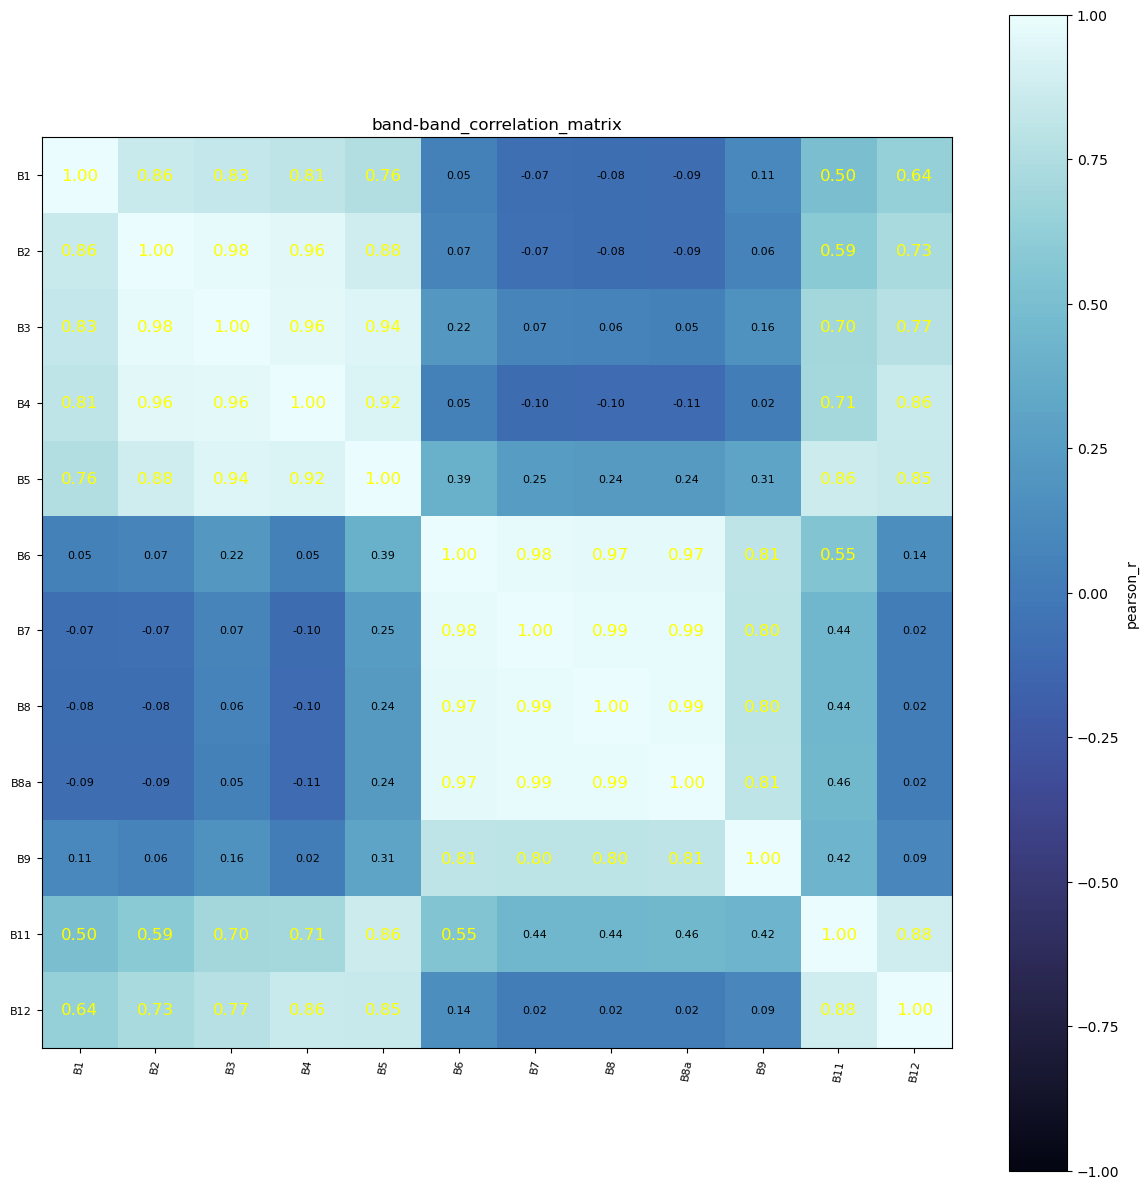

In [57]:

corr = correlation_matrix(no_nan_data, band_labels=[labels.split()[0] for labels in labels])

In [22]:
"""
IGNORE THE SCRIBBLES BELOW:
problem 3b:
- B2, B3, B4, B8 (only 10 m bands), need to define a function that creates two subplots:
    - pairwise scatter plot b/w every two vectors = this a good "linear" relationship assessment. similar to a pairplot.
    - density of scatter plot b/w every two vectors. This is useful for visualising areas where data points are more concentrated (more than one technique, pick what I like?)
        basically show the concentration where the points are all piled up. scatter plot doesnt really show anything, show as in there is no easy way to intuitively understand where does this "density in the scatter plot" point to in the original sentinel2 data of ROC. Right?
        BUt for this hw i do not need to point those desnsities to their respective geographic locations. Only a desntiy map for the scatter plot is enough I guess


--> analyze the observed patterns and describe any significant trends or clusters in data.
correlation_plot(Args)



nah searched it up:
Correlation Density Types
Density plots are used to visualize the distribution of a single variable or the joint distribution of two variables, and they can be effectively combined with correlation analysis. When examining the relationship between two variables (or "bands" in some contexts), several types of density-based visualizations exist to complement correlation plots.

A common approach is to use a 2D density plot, which shows the joint distribution of two numeric variables. This can be visualized in several ways:

- Contour plots display lines of equal density, highlighting regions of high concentration.
 These are created using functions like stat_density_2d() in ggplot2.
- Filled polygon plots represent the density as colored areas, where the fill color corresponds to the density level.
- Raster plots use a grid of colored cells to represent the density, providing a smooth, continuous appearance.
- Hexbin charts divide the plot area into hexagonal bins, with each bin's color indicating the number of observations within it, offering a discrete approximation of density.
- 2D histograms use square bins instead of hexagons to count observations in each cell, similar to a 2D version of a standard histogram.
These 2D density visualizations are particularly useful for large datasets where overlapping points in a scatterplot obscure the underlying pattern.
 They can be combined with marginal distributions (e.g., histograms or density curves) to show both the joint relationship and the individual distributions of each variable.
 This combination helps in assessing correlation while also understanding the shape of each variable's distribution.

Additionally, kernel density estimation (KDE) is the underlying method used to create smooth density curves for single variables, and it can be extended to two dimensions.
 The smoothness of the resulting plot is controlled by a bandwidth parameter, which affects how much the data is smoothed.
 While not a direct correlation plot, the density plot can reveal patterns such as multimodal distributions or skewness that influence the interpretation of correlation.

In summary, the main types of density plots relevant to analyzing the relationship between two variables include contour plots, filled polygon plots, raster plots, hexbin charts, and 2D histograms, all of which can be used alongside or integrated into correlation visualizations to provide deeper insight into the data's structure.

I like hexbin. Looks intuitive. https://datavizproject.com/data-type/hexagonal-binning/


"""

'\nproblem 3b:\n- B2, B3, B4, B8 (only 10 m bands), need to define a function that creates two subplots:\n    - pairwise scatter plot b/w every two vectors = this a good "linear" relationship assessment. similar to a pairplot.\n    - density of scatter plot b/w every two vectors. This is useful for visualising areas where data points are more concentrated (more than one technique, pick what I like?)\n        basically show the concentration where the points are all piled up. scatter plot doesnt really show anything, show as in there is no easy way to intuitively understand where does this "density in the scatter plot" point to in the original sentinel2 data of ROC. Right?\n        BUt for this hw i do not need to point those desnsities to their respective geographic locations. Only a desntiy map for the scatter plot is enough I guess\n\n\n--> analyze the observed patterns and describe any significant trends or clusters in data.\ncorrelation_plot(Args)\n\n\n\nnah searched it up:\nCorrel

In [23]:
def correlation_plot(img: np.ndarray,
                     band_indices: list[int],
                     band_labels: list[str] | None = None,
                     sample: int = 100_000,
                     density: str = "hexbin",
                     gridsize: int = 80, # for hexbin
                     bins: int = 120): # for hist2d
    """
    Creating for every pair of bands:
        - plot 1 (left side): scatter plot that is created by subsampling.
        - plot 2 (right side): density plot where I include hexbin and hist2d, which I had read about in perplexity summaries and viewed the example images of
                               decided to go with hexbin finally. Felt intuitive to understand.
    img: (height, width, band) array with nans for no data.
    band_indices: list of band indices
    band_labels: list of band labels to be shown on the axes of every plot.
                 default value given to be B{i}.
    """
    assert img.ndim == 3, f"expect (height, width, channels) shape: {img.shape}"
    assert len(band_indices) >= 2, "band_indices must contain at least 2 elements"

    H, W, B = img.shape
    for idx in band_indices:
        if not (0 <= idx < B):
            raise ValueError(f"band index {idx} must be in [0, {B-1}]")

    X = img.reshape(-1, B)[:, band_indices]
    valid = np.all(np.isfinite(X), axis=1)
    X = X[valid]
    if X.size == 0:
        raise ValueError("there are 0 valid pixels after filtering out nans (no data)")

    if band_labels is None:
        ax_lbls = [f"B{idx}" for idx in band_indices]  # fixed
    else:
        if len(band_labels) != len(band_indices):
            raise ValueError(f"band_labels must match band_indices length ({len(band_indices)})")
        ax_lbls = band_labels

    k = len(band_indices)
    pairs = [(i, j) for i in range(k) for j in range(i+1, k)]
    rng = np.random.default_rng(0) #for scatter the sample limit points only for speed, (since we have close to 700k points, i sample upto 100k)

    for i, j in pairs:
        xi, xj = X[:, i], X[:, j]  # grabbing all reflectances for band i and j; xi is vector of for band i, and similarly for xj
        n = xi.shape[0]
        if (sample is None) or (sample >= n):
            xs, ys = xi, xj
        else:
            sel = rng.choice(n, sample, replace=False)
            xs, ys = xi[sel], xj[sel]


        r = float(np.corrcoef(xi, xj)[0, 1])
        xmin, xmax = np.nanpercentile(xi, [0.5, 99.5])
        ymin, ymax = np.nanpercentile(xj, [0.5, 99.5])

        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        ax[0].plot(xs, ys, '.', ms=1, alpha=0.3)  # scatter points at (xi, xj)
        ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax) # only plotting 0.5 - 99.5 percentile values to reduce extreme outliers
        ax[0].set_aspect('equal', 'box')
        ax[0].set_xlabel(ax_lbls[i]); ax[0].set_ylabel(ax_lbls[j])
        ax[0].set_title(f"scatter - {ax_lbls[i]} vs {ax_lbls[j]}\npearson r = {r:.2f}")

        if density == "hexbin":
            hb = ax[1].hexbin(xi, xj, gridsize=gridsize, mincnt=1, cmap=cmo.cm.thermal)
            fig.colorbar(hb, ax=ax[1], label="counts")
        elif density == "hist2d":
            h, xe, ye, im = ax[1].hist2d(xi, xj, bins=bins, cmap=cmo.cm.thermal)
            fig.colorbar(im, ax=ax[1], label="counts")
        else:
            raise ValueError("density must be 'hexbin' or 'hist2d'")

        ax[1].set_xlim(xmin, xmax); ax[1].set_ylim(ymin, ymax)
        ax[1].set_aspect('equal', 'box')
        ax[1].set_xlabel(ax_lbls[i]); ax[1].set_ylabel(ax_lbls[j])
        ax[1].set_title(f"density ({density})")

        plt.tight_layout(); plt.show()


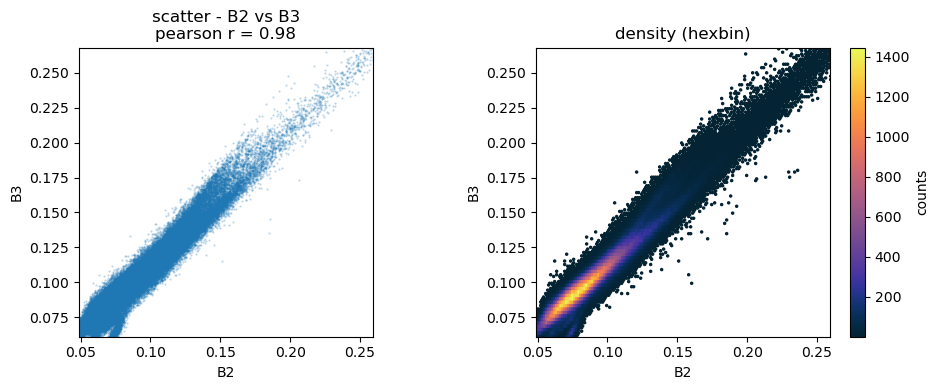

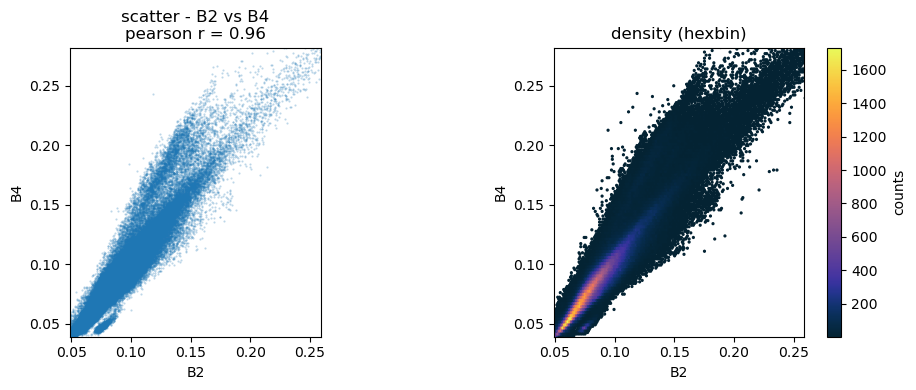

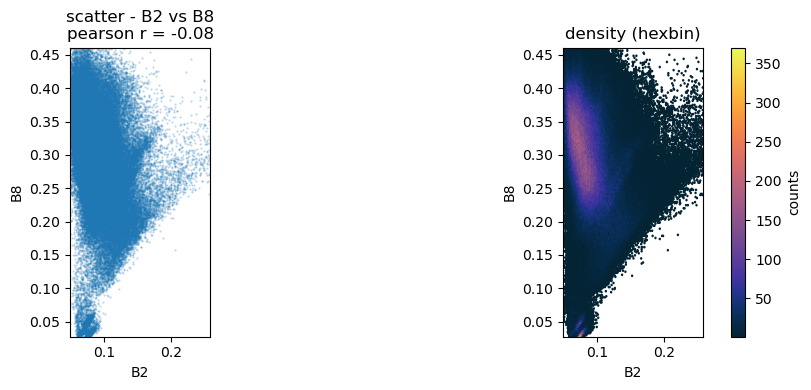

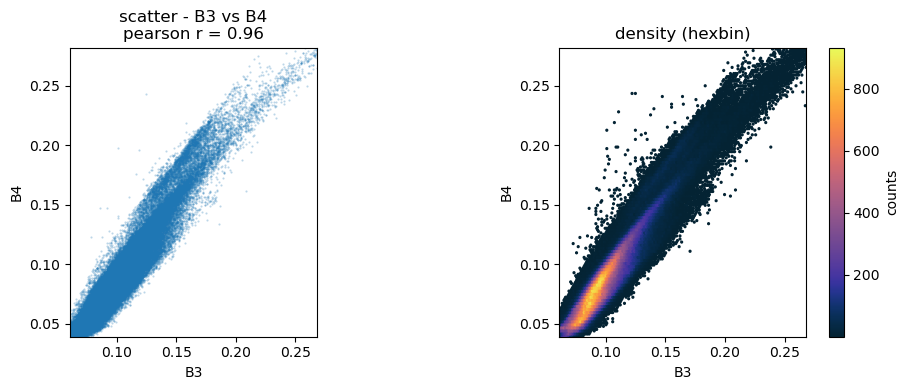

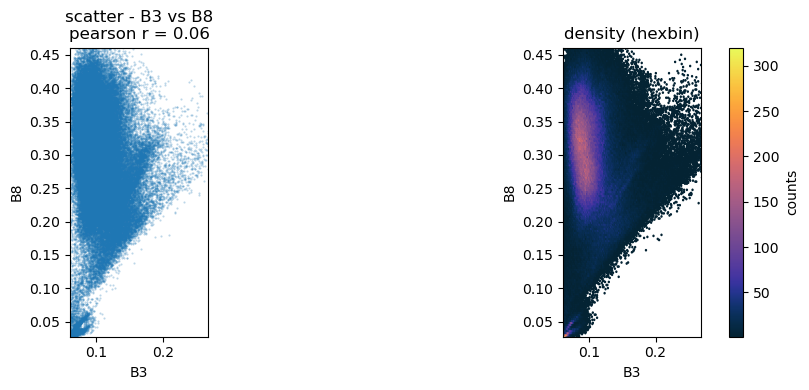

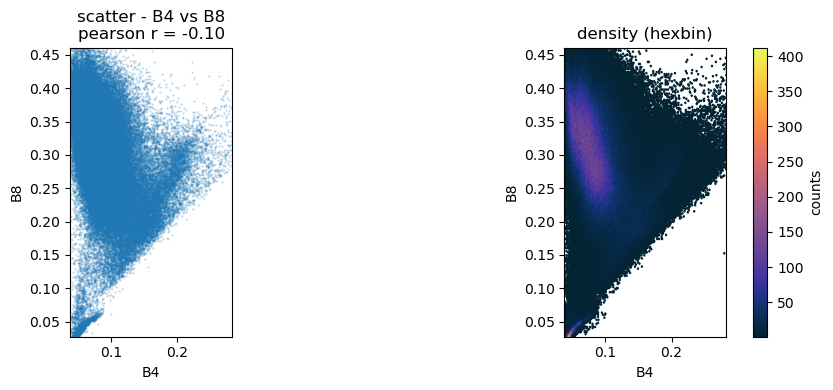

In [24]:
# now lets call for the 4 10 m bands
band_names = [b.split()[0].upper() for b in labels]
requested = ["B2", "B3", "B4", "B8"] # 10 m ones only
band_idx = [band_names.index(b) for b in requested]
band_labels = requested
correlation_plot(no_nan_data,band_idx,band_labels, sample = 100_000, density = "hexbin", gridsize = 500) #chose gridsize 500 for better detail.


In [25]:
"""problem 3 b observations:
- Firstly, all the following three pairs have strong r values because they belong in the visible band (Red, Gree, Blue). And from the pixel value distributions, and also intuition, their reflectances are very close from any kind of surface (water-bodies/vegetation/builtup-land).
    1. B2 vs B3: ( Blue vs Green)
        r = 0.98, extremely strong. They rise or fall together.
        They are of low pixel values <=> their reflectances are low.
        Their wavelengths according to the website was B2 = 490 nm, B3 = 560 nm: very close, so most surfaces reflect these similarly.
    2.  B4 vs B2: (Red vs Blue)
        r = 0.96, similarly strong. They rise or fall together
    3. B3 vs B4: (Green vs Red)
        r = 0.96, similarly strong. They rise or fall together.

- Whereas wrt to B8 (NIR), they have weak (positive & negative) r values. Which means it has weak "linear" relationship with the visible bands. Makes sense as it is Near Infrared.
From the website, it is mentioned that B8 (NIR) are good at reflecting chlorophyll. Hence where there is denser vegetation, the B8 band values will be higher, and the density associated with the visbile spectrum.
    1. The density plots associated with (B3 vs B8), (B4 vs B8), and (B2 vs B8) are in that oval shape that is very distinct from the other highly correlated density shapes. Which would suggest that there is some sort of a "non-linear" relationship amongst those bands.

Hence, the density plots which are oval/elongated shape, most likely represent a presence of a strong/weak "non-linear" relationship worth exploring.
The others which are "dashed" and "widespread" might hint at a huge coverage of land and water bodies(maybe).


"""

'problem 3 b observations:\n- Firstly, all the following three pairs have strong r values because they belong in the visible band (Red, Gree, Blue). And from the pixel value distributions, and also intuition, their reflectances are very close from any kind of surface (water-bodies/vegetation/builtup-land).\n    1. B2 vs B3: ( Blue vs Green)\n        r = 0.98, extremely strong. They rise or fall together.\n        They are of low pixel values <=> their reflectances are low.\n        Their wavelengths according to the website was B2 = 490 nm, B3 = 560 nm: very close, so most surfaces reflect these similarly.\n    2.  B4 vs B2: (Red vs Blue)\n        r = 0.96, similarly strong. They rise or fall together\n    3. B3 vs B4: (Green vs Red)\n        r = 0.96, similarly strong. They rise or fall together.\n\n- Whereas wrt to B8 (NIR), they have weak (positive & negative) r values. Which means it has weak "linear" relationship with the visible bands. Makes sense as it is Near Infrared.\nFrom th

In [26]:
"""
Problem 4:
ECOSTRESS data provides spectral reflectance across the electromagnetic spectrum.
Need to compare this data with that of sentinel2's data.
Must spectral data covering 0.35 - 2.5 micron. =>
    1. vegetation one: min_value = 0.35, max_value = 2.5 micron
    2. manmade one: min_value = 0.42, max_value = 14.00 micron: will have to filter out or "downsample" or something. Need to explore.
Yes the spectral library data must be spectrally downsampled to the Sentinal bands.
    1. Cosine similarity concept to be used to identify first 100 pixels in Sentinel data that have the lowest spectral angle, when compared to the new samples.
    2. Plotting the spectra of the 1st, 50th, 100th closest matches alongside the original ECOSTRESS spectra.
Q1. Analyze how closely the matches resemble the ECOSTRESS data and explain the similarities or differences.
Q2. How would I pick a cut-off angle and use that as a threshold to grab all the vegetation/road pixels in my sentinel2 imagery?
Q3. Represent the pixels I have identified in the image with my favourite approach...hmm.

My understanding of the downloaded files:
- .spectrum.txt = the one to focus on. Contains 2 columns: wavelenght(micron), reflectance(percentage 1-100). This is what I downsample to Sentinel2.
- .ancillary.txt = just metadata for the vegetation spectrum txt.
- Manifest.txt = list of included files.


How would I proceed:
- first parse the arrays of wavelength, reflectance from both the .spectrum.txt.
- Preprocess the data = must keep only 0.35-2.5 micron(basically within our sentinel2 wavelength limit). Veg is in this limit. Manmade isn't (0.42 - 14 micron). Need to downsample it to 0.35-2.5, and remove exclude 0.443 micron (B1), and 0.940 micron (B9 SWIR). Convert reflectance to 0-1 by div with 100. And also must exclude 1.375 micron (B10) since it is also excluded from our sentinel2 data.  I can average the reflectances for each of the remaining bands, around the bands centre. what should be the window length be?
- compute the SAM = spectral angle between each pixel vector and each ecostress vector. must pick the 100 smallest angles <=> best matches.
- plot the spectra of the 1st, 50th, 100th closest matches against each ecostress vector. How? Line plot across the band centres..
- pick a threshold and map all the pixels under that cut as oak/asphalt. How do I visualise this?


"""

'\nProblem 4:\nECOSTRESS data provides spectral reflectance across the electromagnetic spectrum.\nNeed to compare this data with that of sentinel2\'s data.\nMust spectral data covering 0.35 - 2.5 micron. =>\n    1. vegetation one: min_value = 0.35, max_value = 2.5 micron\n    2. manmade one: min_value = 0.42, max_value = 14.00 micron: will have to filter out or "downsample" or something. Need to explore.\nYes the spectral library data must be spectrally downsampled to the Sentinal bands.\n    1. Cosine similarity concept to be used to identify first 100 pixels in Sentinel data that have the lowest spectral angle, when compared to the new samples.\n    2. Plotting the spectra of the 1st, 50th, 100th closest matches alongside the original ECOSTRESS spectra.\nQ1. Analyze how closely the matches resemble the ECOSTRESS data and explain the similarities or differences.\nQ2. How would I pick a cut-off angle and use that as a threshold to grab all the vegetation/road pixels in my sentinel2 ima

In [27]:
# first creating a helper for parsing through the ecostress .spectrum.txt file to return a ndarray(wavelenth, reflectance)
def read_ecostress(path: str):
    """
    I am keeping only the numeric rows, convert reflectance from 0-100 (%) to 0-1, keep only the S2 relevant spectral range(0.35 -2.5 micron).
    """
    data = []
    with open(path, "r") as f:
        for line in f:
            tokens = line.strip().split()
            if len(tokens) < 2:
                continue
            try:
                wavelength = float(tokens[0])
                reflectance = float(tokens[1])
                data.append((wavelength, reflectance))
            except ValueError:
                continue
    data = np.array(data, dtype=float)
    wavelength_um = data[:,0]
    refl = data[:,1]/100.0 # dividing the reflectance values with 100
    clip = (wavelength_um >= 0.35) & (wavelength_um <= 2.5)
    return wavelength_um[clip], refl[clip]




In [58]:
# read_ecostress('manmade.road.pavingasphalt.solid.all.0095uuuasp.jhu.becknic.spectrum.txt')

In [29]:
# sentinel2 band widths found reference this website https://seadas.gsfc.nasa.gov/help-9.2.0/Sentinel2Overview.html
# values are (center, width nanometer) this is converted to micron.
s2b = {    "B2":  (492.4,  66.0),
    "B3":  (559.8,  36.0),
    "B4":  (664.6,  31.0),
    "B5":  (704.1,  15.0),
    "B6":  (740.5,  15.0),
    "B7":  (782.8,  20.0),
    "B8":  (832.8, 106.0),
    "B8A": (864.7,  21.0),
    "B11": (1613.7, 91.0),
    "B12": (2202.4, 175.0)} # skipped B1, B9 and B10
s2_bands = [(k,s2b[k][0]/1000.0,s2b[k][1]/1000.0) for k in ("B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12")] # converted them to microns from nano meters
band_names = [b for b,_,_ in s2_bands]
band_centers = np.array([c for _,c,_ in s2_bands])
band_widths = np.array([w for _,_,w in s2_bands])
# s2_bands

In [30]:
# downsampling across the ecostress spectrums to s2 bands so that we can have a 10 dimensional vector/1 reflectance per s2 band
def downsample_to_s2(wavelengths, reflectances,band_centers, band_widths):
    """
    box - average the high-res ECOSTRESS spectrum into each S2 bandpass
   for each S2 band:
      -build the passband [center - width/2, center + width/2],
      -select ECOSTRESS samples falling inside that interval,
      -average reflectance within that interval (NaN if no samples).
    Returns: array with one reflectance per S2 band (length = 10).
    """
    s2_reflectances = []
    for c, w in zip(band_centers, band_widths):
        low, high = c-w/2, c+w/2
        m = (wavelengths>=low) & (wavelengths<=high) # i am marking which ecostress wavelengths fall inside the sentinel2 band interval.
        if not np.any(m):
            s2_reflectances.append(np.nan) # in case of no values in that m range, then nan.
        else:
            s2_reflectances.append(np.nanmean(reflectances[m])) #mean aggregate taken for the reflectances for that sentinel2 band.
    return np.array(s2_reflectances)



In [31]:
# computing the spectral angle mapper: using the forumla. If low angle then that spectra more similar. To be applied b/w each s2 spectrum & ecostress reference spectrum
def sam(v1, v2):
    x = np.nansum(v1 * v2)
    norm1 = np.sqrt(np.nansum(v1**2))
    norm2 = np.sqrt(np.nansum(v2**2))
    denom = norm1 * norm2
    if denom == 0 or not np.isfinite(denom):
        return np.nan
    return np.arccos(np.clip(x / denom, -1.0, 1.0))

In [32]:
# top-100 matches. flatten the s2 to 2d. sort & note 1, 50, 100 lowest angles
def find_top_100(img, ref, top_k = 100):
    """
    compute SAM b/w each pixel spectrum and a reference spectrum
    returns angles (H*W,) array of SAM angles
    top indices - indices of the smallest top-k angles
    """
    ht, wd, band = img.shape
    x = img.reshape(-1, band)
    angles = np.array([sam(x,ref) for x in x])
    angles_sorted = np.argsort(angles)
    return angles, angles_sorted[:top_k]


In [33]:
# plotting the spectra
def plot_matches(img, indices, ref, band_names, title):
    """plotting ECOSTRESS ref spectrum vs 1/50/100 best pixel matches"""
    x = img.reshape(-1, img.shape[-1])
    plt.figure(figsize=(9,5))
    for k in [0, 49, 99]:
        plt.plot(band_names, x[indices[k]], label=f"match {k+1}")
    plt.plot(band_names, ref, 'k--', lw=2, label="ECOSTRESS reflectance")
    plt.xlabel("sentinel-2 bands")
    plt.ylabel("reflectance")
    plt.title(title)
    plt.legend()
    plt.show()

In [34]:
# was thinking how to choose a cutoff for the angle.
# okay the workflow of using the above functions:
veg_wl, veg_refl = read_ecostress('vegetation.tree.quercus.lobata.vswir.vh090.ucsb.asd.spectrum.txt')
road_wl, road_refl = read_ecostress('manmade.road.pavingasphalt.solid.all.0095uuuasp.jhu.becknic.spectrum.txt')
# veg_wl

In [35]:
# downsampling them to sentinel 2 bands
veg_refl_s2 = downsample_to_s2(veg_wl, veg_refl, band_centers, band_widths)
road_refl_s2 = downsample_to_s2(road_wl, road_refl, band_centers, band_widths)


In [36]:
# finding top 100 s2 matches for each
veg_angles, veg_top100 = find_top_100(no_nan_data[:,:,[1,2,3,4,5,6,7,8,10,11]], veg_refl_s2, top_k=100) # making sure that no_nan_data is also of 10 bands instead of 12, removed B1 B9
road_angles, road_top100 = find_top_100(no_nan_data[:,:,[1,2,3,4,5,6,7,8,10,11]], road_refl_s2, top_k=100)

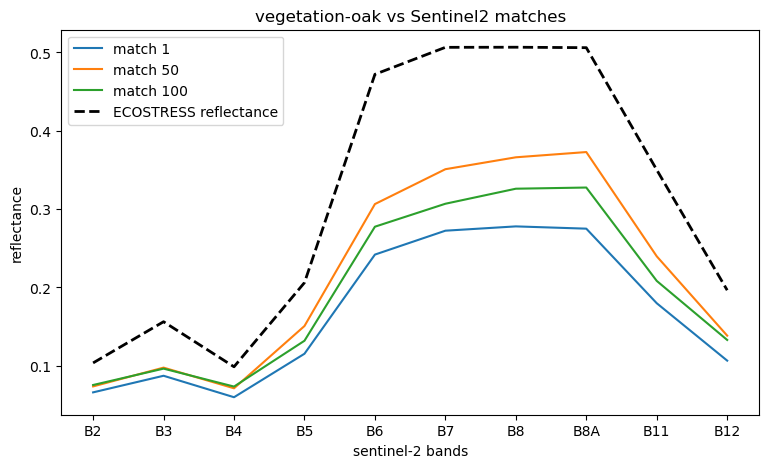

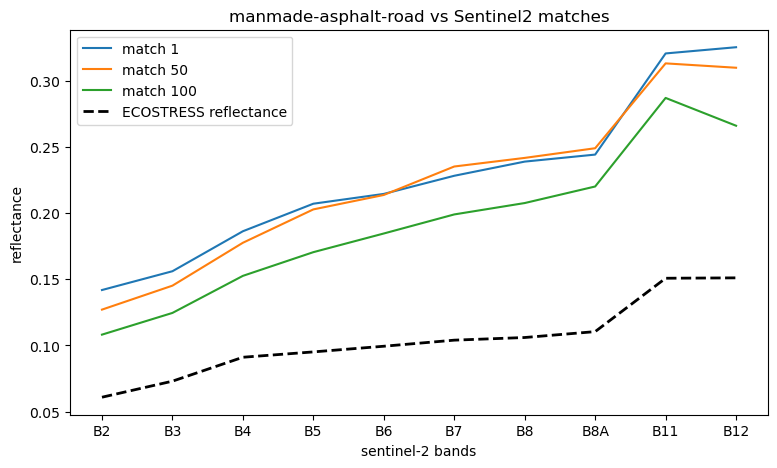

In [37]:
# plotting the spectra for 1st 50th 100th percentile
plot_matches(no_nan_data[:,:,[1,2,3,4,5,6,7,8,10,11]], veg_top100, veg_refl_s2, band_names, "vegetation-oak vs Sentinel2 matches")
plot_matches(no_nan_data[:,:,[1,2,3,4,5,6,7,8,10,11]], road_top100, road_refl_s2, band_names, "manmade-asphalt-road vs Sentinel2 matches")


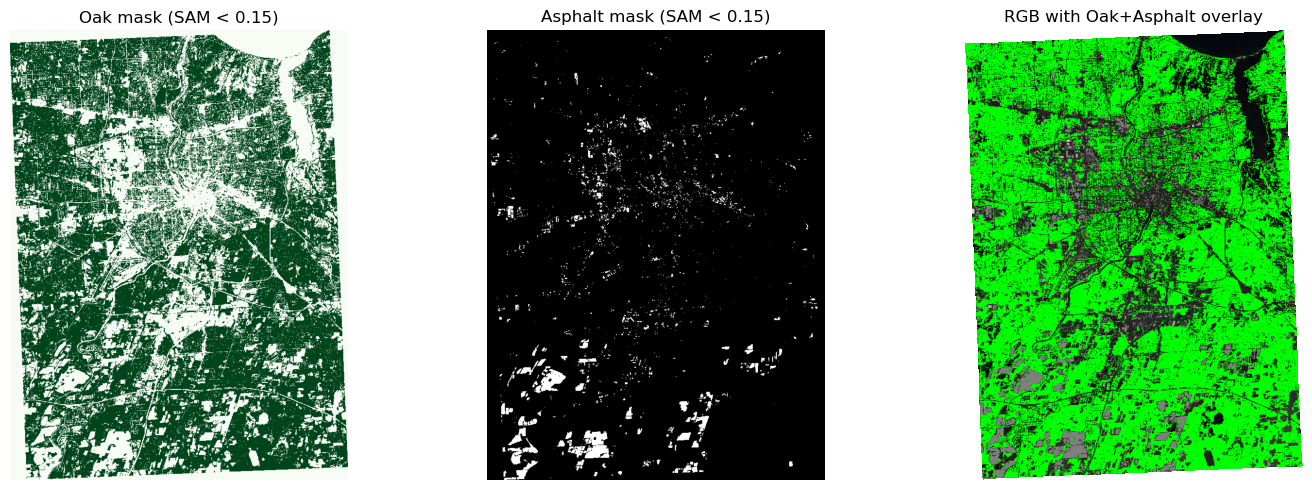

In [38]:
# reshape angles back into image grids
veg_angle_img = veg_angles.reshape(no_nan_data.shape[:2])
road_angle_img = road_angles.reshape(no_nan_data.shape[:2])

# choose threshold (tune!)
threshold = 0.15

# create masks
veg_mask = veg_angle_img < threshold
road_mask = road_angle_img < threshold

# visualize the oak and the asphalt separately along with a one on the side with an RGB mask for better comparison
plt.figure(figsize=(15,5))

# oak and road masks
plt.subplot(1,3,1)
plt.imshow(veg_mask, cmap="Greens")
plt.title(f"Oak mask (SAM < {threshold})")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(road_mask, cmap="gray")
plt.title(f"Asphalt mask (SAM < {threshold})")
plt.axis("off")

# now I am creating an rgb overlay
rgb = np.dstack([
    minmax_stretch(no_nan_data[:,:,3]),  # red band (B4)
    minmax_stretch(no_nan_data[:,:,2]),  # green band (B3)
    minmax_stretch(no_nan_data[:,:,1]) # blue band (B2)
])

overlay = rgb.copy()
overlay[veg_mask] = [0,1,0]  # green overlay for oak
overlay[road_mask] = [0.5,0.5,0.5] #gray overlay for asphalt

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("RGB with Oak+Asphalt overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [39]:
"""
seems to work pretty well
"""

'\nseems to work pretty well\n'